https://www.kaggle.com/zhangyang/bldcv-sz512pad-0709

https://www.kaggle.com/c/diabetic-retinopathy-detection/discussion/16149#latest-542642

Hello, are the labels good for you? we found that our model can not convergence on the validation data from the test dataset, is your model work well on the test data by this label file?

# params

In [1]:
dbg = False
if dbg:
    dbgsz = 500


PRFX = 'DevVerifyDiabTestData0720-1'    
p_o = f'../output/{PRFX}'
from pathlib import Path
Path(p_o).mkdir(exist_ok=True)


SEED = 111

BS = 32
SZ = 512
FP16 = False


from fastai.vision import *
params_tfms = {}

resize_method = ResizeMethod.PAD
padding_mode = 'zeros'

# setup

In [2]:
import fastai
print('fastai.__version__: ', fastai.__version__)

import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

fastai.__version__:  1.0.54


# preprocess

In [3]:
img2grd = []

# p = '../input/aptos2019-blindness-detection'
# pp = Path(p)
# train = pd.read_csv(pp/'train.csv')
# test  = pd.read_csv(pp/'test.csv')
# len_blnd = len(train)
# len_blnd_test = len(test)

# img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

# len_blnd, len_blnd_test

In [4]:
# img2grd += img2grd_blnd
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())

In [5]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

# train=pd.read_csv(pp/'trainLabels.csv')
# img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1])  for o in train.values]
# img2grd += img2grd_diab_train
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1])  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


53576

[(0, 39533), (2, 7861), (1, 3762), (3, 1214), (4, 1206)]

In [6]:
# p = '../input/IDRID/B. Disease Grading'
# pp = Path(p)

# train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
# img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1])  for o in train.values]
# img2grd += img2grd_idrid_train
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())

# test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
# img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1])  for o in test.values]
# img2grd += img2grd_idrid_test
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())

In [7]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [8]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

df.shape

(53576, 2)

In [9]:
df = df.sample(frac=0.2)

# dataset

In [10]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_by_rand_pct(0.2)
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz, 
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 12.9 s, sys: 5.79 s, total: 18.7 s
Wall time: 13.9 s


CPU times: user 5.13 s, sys: 2.17 s, total: 7.29 s
Wall time: 47.7 s


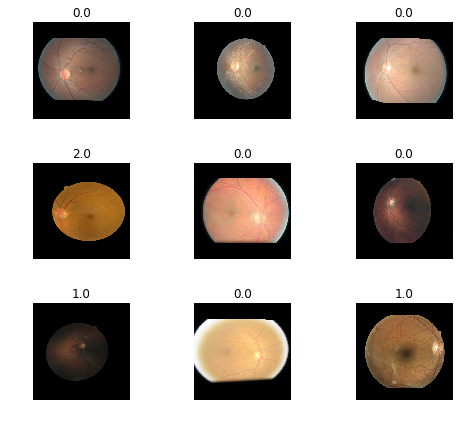

In [11]:
%%time
data.show_batch(rows=3, figsize=(7,6))

# model

In [12]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

In [13]:
learn.freeze()

In [14]:
set_torch_seed()
learn.fit_one_cycle(6, max_lr=1e-3, callbacks=[SaveModelCallback(learn, name=f'{PRFX}_model_frozen')])

epoch,train_loss,valid_loss,time
0,1.561298,0.848219,15:07
1,0.817803,0.649690,15:54
2,0.618875,0.540703,16:31
3,0.525262,0.506426,17:15
4,0.478475,0.462139,16:27
5,0.456725,0.462867,16:12


Better model found at epoch 0 with valid_loss value: 0.8482191562652588.
Better model found at epoch 1 with valid_loss value: 0.6496900916099548.
Better model found at epoch 2 with valid_loss value: 0.5407025814056396.
Better model found at epoch 3 with valid_loss value: 0.5064257979393005.
Better model found at epoch 4 with valid_loss value: 0.46213918924331665.


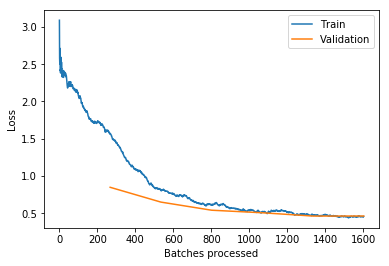

In [15]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [16]:
!nvidia-smi

Sat Jul 20 22:11:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    51W / 300W |  15449MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# validate and thresholding

In [17]:
learn = learn.to_fp32()

In [18]:
%%time
set_torch_seed()
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 8.72 s, sys: 5.48 s, total: 14.2 s
Wall time: 3min 10s


In [19]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [20]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [21]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [22]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [23]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [24]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [25]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 12.1 s


In [26]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


In [27]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.5000660342883434,
  2.000066034288343,
  2.500066034288343],
 'abhishek': array([0.620219, 1.25677 , 1.674522, 3.839305])}

In [28]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [29]:
optnm2qwk

{'simple': 0.6594563823644479,
 'hocop1': 0.6627346801948831,
 'abhishek': 0.7065459425731766}

In [30]:
Counter(y_val).most_common()

[(0.0, 1591), (2.0, 308), (1.0, 151), (4.0, 51), (3.0, 42)]

In [31]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [32]:
preds_val_grd.mean()

0.40737284181054595

In [33]:
Counter(preds_val_grd).most_common()

[(0.0, 1543), (1.0, 421), (2.0, 99), (3.0, 66), (4.0, 14)]

In [34]:
list(zip(preds_val_grd, y_val))[:10]

[(4.0, 4.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (3.0, 2.0),
 (0.0, 2.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 2.0),
 (1.0, 2.0)]

In [35]:
(preds_val_grd== y_val.squeeze()).mean()

0.6868875408306113

In [36]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [37]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_val_grd = bucket(preds_val, coef)
    display(pd.Series(preds_val_grd.squeeze().astype(int)).value_counts())

simple 0.6594563823644479 [0.5, 1.5, 2.5, 3.5]


0    1543
1     421
2      99
3      66
4      14
dtype: int64

hocop1 0.6627346801948831 [1.0000660342883434, 1.5000660342883434, 2.000066034288343, 2.500066034288343]


0    1855
1     109
4      80
2      54
3      45
dtype: int64

abhishek 0.7065459425731766 [0.620219 1.25677  1.674522 3.839305]


0    1669
1     263
3     151
2      54
4       6
dtype: int64

# testing

## submit